# Ann Arbor Housing Survey: Exploratory Data Analysis
<hr>

In [100]:
# how do I install this?!
import dtale 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import re
import json

In [101]:
df = pd.read_json('../data/cleaned_data/aggregated.json')
# a little look at the data
df.head()
# dtale.show(df)

,address,price,bed,bath,area,company,neighborhood,laundry,pets,parking,utilities,property_type,year_built,description,images
0,3050 Birch Hollow Dr,1095.0,2.0,1.0,876.0,None,None,1.0,1.0,1.0,[],apartment,NaN,This bedroom apartments includes:\n\n→ Contemp...,[https://images.craigslist.org/00S0S_8ZkasrSZ6...
1,912 Rose Ave,2000.0,4.0,2.5,2000.0,None,None,1.0,1.0,1.0,[],house,NaN,"Stunning Ann Arbor home, perfect family house ...",[https://images.craigslist.org/00Y0Y_4tey2xf24...
2,None,695.0,3.0,2.0,NaN,None,None,1.0,0.0,1.0,[],apartment,NaN,"AWESOME Affordable. This stunning 3 bedroom, 1...",[]
3,1505 Natalie Lane near Kipling Drive,1385.0,1.0,1.0,800.0,None,None,1.0,1.0,1.0,[],apartment,NaN,Have you heard about our Stars & Stripes progr...,[https://images.craigslist.org/00p0p_1PnkFaSsW...
4,1505 Natalie Lane near Kipling Drive,1185.0,1.0,1.0,800.0,None,None,1.0,1.0,1.0,[],apartment,NaN,Have you heard about our Stars & Stripes progr...,[https://images.craigslist.org/00k0k_7n7PgfXF5...


In [102]:
df.describe()

,price,bed,bath,area,laundry,pets,parking,year_built
count,7818.000000,8519.000000,9203.000000,5965.000000,7302.000000,7302.000000,7302.000000,1766.000000
mean,1583.984971,2.094847,1.414919,978.319950,0.944399,0.492468,0.644618,1974.872593
std,1095.510351,1.566232,0.782912,548.638798,0.229166,0.499977,0.478662,34.674417
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1870.000000
25%,989.000000,1.000000,1.000000,658.000000,1.000000,0.000000,0.000000,1964.000000
50%,1299.000000,2.000000,1.000000,888.000000,1.000000,0.000000,1.000000,1987.000000
75%,1725.000000,2.000000,2.000000,1100.000000,1.000000,1.000000,1.000000,1998.000000
max,15900.000000,12.000000,10.000000,8500.000000,1.000000,1.000000,1.000000,2020.000000


### Distribution of Price

The first graph (excluding some very high outliers around 15000) shows a histogram and KDE of the overall price distribution. The second graph uses a log-linear scale and plots both the histogram and a rug plot to give a better impression of the actual price distribution; the plot shows characteristics of a long tail. 

In [103]:
# drop obvious mistakes
df = df[df['price'] > 300]

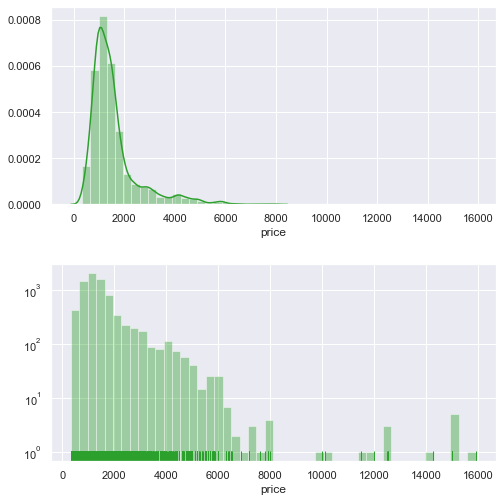

In [104]:
sns.set(style='darkgrid')
plt.subplots(2, 1, figsize=(7,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.subplot(2, 1, 1)
ax1 = sns.distplot(df['price'], kde_kws={'bw':150, 'clip':[-1000, 10000]}, bins=48, color='#2ca02c')
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(2, 1, 2)
ax2 = sns.distplot(df['price'], bins=48, color='#2ca02c', kde=False, rug=True)
ax2.set_yscale('log')
plt.savefig('figures/price-dist.png', dpi=300)

Some descriptive statistics of the price distribution:

In [105]:
df['price'].describe()

count     7798.000000
mean      1587.872467
std       1094.210235
min        336.000000
25%        989.000000
50%       1300.000000
75%       1725.000000
max      15900.000000
Name: price, dtype: float64

Let's examine these outliers...

In [107]:
expensive = df[df['price'] > 12000]
expensive.head()

,address,price,bed,bath,area,company,neighborhood,laundry,pets,parking,utilities,property_type,year_built,description,images
1803,39 Menlo Park,15900.0,2.0,2.0,1056.0,None,None,1.0,0.0,1.0,[],None,NaN,39 MENLO PARK: 1992 Redman. 2-bedroom 2-bathro...,[https://images.craigslist.org/00303_5qJMibIEa...
3730,"10 br, 3 bath House - 725 Church Street",12530.0,10.0,3.0,NaN,None,None,0.0,0.0,1.0,[],apartment,NaN,(734) 663-8989 - 14 Bedroom House - Available...,[]
5605,"725 Church Street, Ann Arbor, MI 48104",12530.0,10.0,3.0,NaN,None,None,NaN,NaN,NaN,[],house,NaN,,[https://s3.amazonaws.com/photos.rentlinx.com/...
7822,"723 Oakland Avenue Ann Arbor, MI 48104",12500.0,9.0,4.0,NaN,"Bartonbrook Properties, LLC",East Packard,1.0,0.0,1.0,"[Recycling, Trash Removal included]",house,NaN,NEW RENOVATIONS!! 9 bedroom house located in a...,[]
7823,"814 Hill Street Ann Arbor, MI 48104",14250.0,10.0,3.0,NaN,"Bartonbrook Properties, LLC",East Packard,1.0,0.0,1.0,"[Recycling, Trash Removal included]",house,NaN,"Beautiful 12 bedroom/3 bath house, WITH UPDATE...",[]


### Distribution of Price per Bedroom

In [108]:
def fix_bed(x):
    try:
        x = float(x)
        if x == 0:
            return np.nan
        return x
    
    except:
        if x == 'room':
            return 1
        return np.nan

df.bed = df.bed.apply(fix_bed).astype(float)

In [109]:
# calculate price per bed

ppb = []
for i, elt in df.iterrows():
    # let's ignore obvious mistakes (ppb < 200)
    tmp = elt['price'] / elt['bed'] if elt['price'] / elt['bed'] >= 300 else elt['price']
    ppb.append(tmp)
    
df['ppb'] = ppb

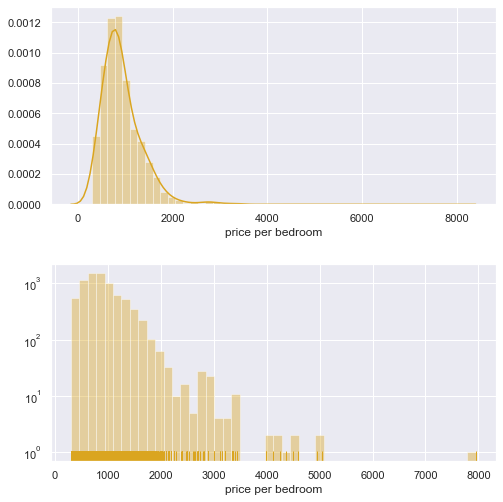

In [110]:
sns.set(style='darkgrid')
plt.subplots(2, 1, figsize=(7,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.subplot(2, 1, 1)
ax1 = sns.distplot(df['ppb'], kde_kws={'bw':150, 'clip':[-1000, 8000]}, bins=48, color='goldenrod')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('price per bedroom')
plt.subplot(2, 1, 2)
ax2 = sns.distplot(df['ppb'], bins=48, color='goldenrod', kde=False, rug=True)
ax2.set_yscale('log')
plt.xlabel('price per bedroom')
plt.savefig('figures/price-by-bed-dist.png', dpi=300)

### Joint Distribution of Price and Area
This plot shows the joint (and marginal) distribution(s) of $\mathrm{log}$(price) and $\mathrm{log}$(area).

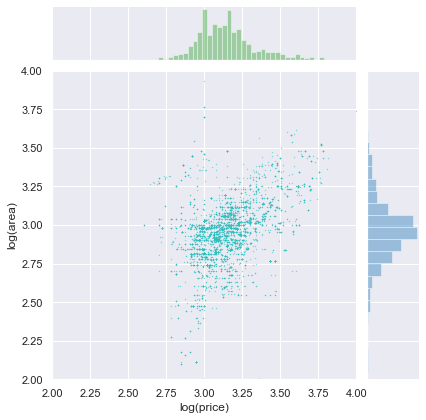

In [111]:
area = df[df['area'].notnull() & df['area'] != 0]['area']
df_plot = df.copy()
df_plot['log(area)'] = area.apply(lambda x: np.log10(x))
df_plot['log(price)'] = df_plot['price'].apply(lambda x: np.log10(x))

# ignore outliers! plot does NOT show long tail
sns.set(style='darkgrid')
g = sns.jointplot('log(price)', 'log(area)', df_plot, kind='scatter', alpha=0.8, s=0.1, color='#30bfbf')
g.ax_joint.set_ylim([2, 4])
g.ax_joint.set_xlim([2, 4])

for patch in g.ax_marg_x.patches:
    patch.set_facecolor('#2ca02c')

for patch in g.ax_marg_y.patches:
    patch.set_facecolor('#1f77b4') 

plt.savefig('figures/area-vs-price.png', dpi=300)

Text(0.5, 1.0, 'Probability plot for normal dist')

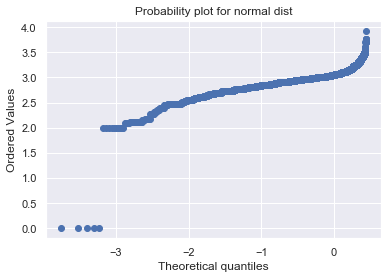

In [128]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = stats.loggamma.rvs(c=2.5, size=500)
res = stats.probplot(df_plot['log(area)'], dist=stats.norm, sparams=(0,1), plot=ax)
ax.set_title("Probability plot for normal dist")

### Correlation Heatmap
The correlation heatmap below shows that intuitive trends are reflected in the data; for instance, we'd expect that price is highly correlated with the number of available bedrooms in a house or apartment. Note that many of the other correlations are relatively weak.

,price,bed,bath,area,laundry,pets,parking,year_built
price,1.000000,0.630296,0.340268,0.460245,-0.066057,-0.195342,-0.081144,0.253818
bed,0.630296,1.000000,0.666135,0.669075,-0.027155,-0.080173,0.076723,-0.237187
bath,0.340268,0.666135,1.000000,0.578336,-0.002040,-0.093690,0.057643,0.221848
area,0.460245,0.669075,0.578336,1.000000,-0.056068,-0.123596,0.066532,0.245898
laundry,-0.066057,-0.027155,-0.002040,-0.056068,1.000000,0.193587,0.203173,0.404787
pets,-0.195342,-0.080173,-0.093690,-0.123596,0.193587,1.000000,0.320473,NaN
parking,-0.081144,0.076723,0.057643,0.066532,0.203173,0.320473,1.000000,0.175739
year_built,0.253818,-0.237187,0.221848,0.245898,0.404787,NaN,0.175739,1.000000


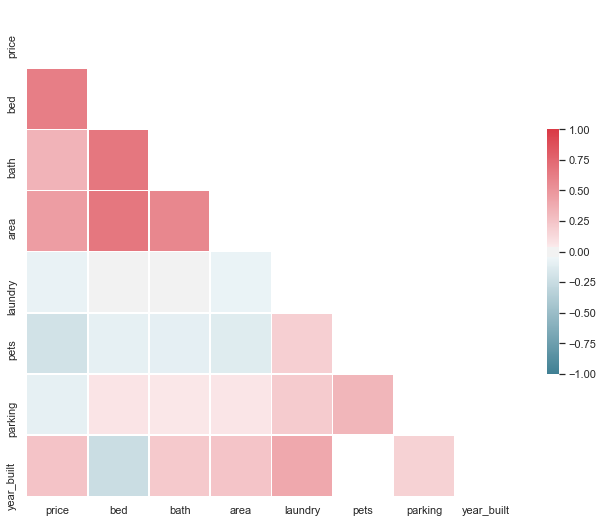

In [13]:
sns.set(style='white')
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('corr-heatmap.png', dpi=300)
corr

### Distribution of Price by Company
We took the 10 most common companies and visualized the distribution of price by each of these companies.

Cabrio Properties                       318
Campus Management, Inc.                 206
PMSI                                    177
Oxford Property Management              176
J Keller Properties                     169
The Hayman Company                      138
Oakland Management Corp.                130
Cappo Management & Deinco Properties    123
Issa Properties                         112
Village Green                           102
Name: company, dtype: int64


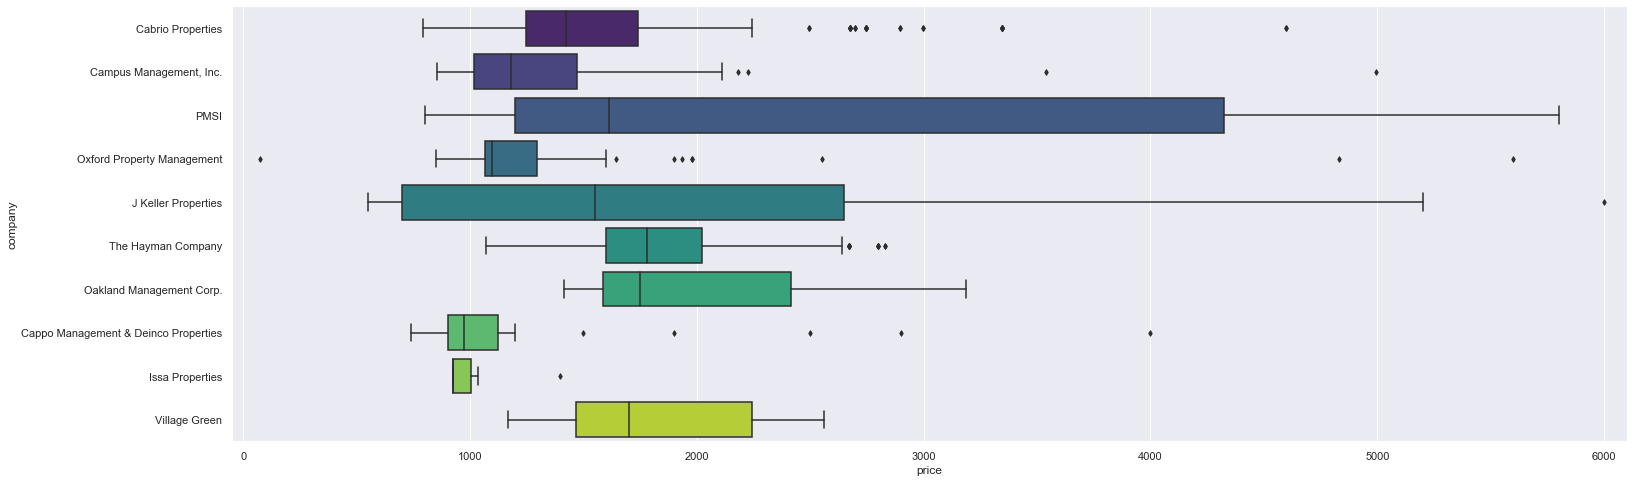

In [200]:
df_plot = df.copy()
companies = df['company'].value_counts().iloc[:10].index.tolist()
print(df['company'].value_counts().iloc[:10])

df_plot = df_plot[df_plot['company'].isin(companies)]
sns.set(style='darkgrid')
plt.subplots(1,1, figsize=(25,8))
sns.boxplot(x='price', y='company', palette="viridis", data=df_plot, fliersize=4, order=companies, saturation=0.8)
plt.xlim([-50, 6100])
plt.savefig('figures/boxplot-company.png', dpi=300)

Let's look at the average price per company for the 20 most frequent companies. Note, since we are calculating error bars for the average price, these are the 20 most frequent companies when only considering listings *with not-null prices*.  

In [267]:
most_common = df.groupby('company').count().sort_values(by='price', ascending=False).index.tolist()[:20]
df_filt = df[df['company'].isin(most_common)]
companies = df_filt.groupby('company')

In [268]:
# compute 95% confidence intervals
means = companies.mean().price.to_numpy()

# sort in descending order by price
indices = np.argsort(means)
error = companies.price.std().to_numpy()[indices]
df_comp = companies.mean().sort_values(by='price')
col = {i: df_comp.index.to_list()[i] for i in np.arange(20)}
df_comp = pd.concat([df_comp.reset_index(), pd.DataFrame(error, columns=['error'])], axis=1)
df_comp = df_comp.rename(index=col).drop('company', axis=1)

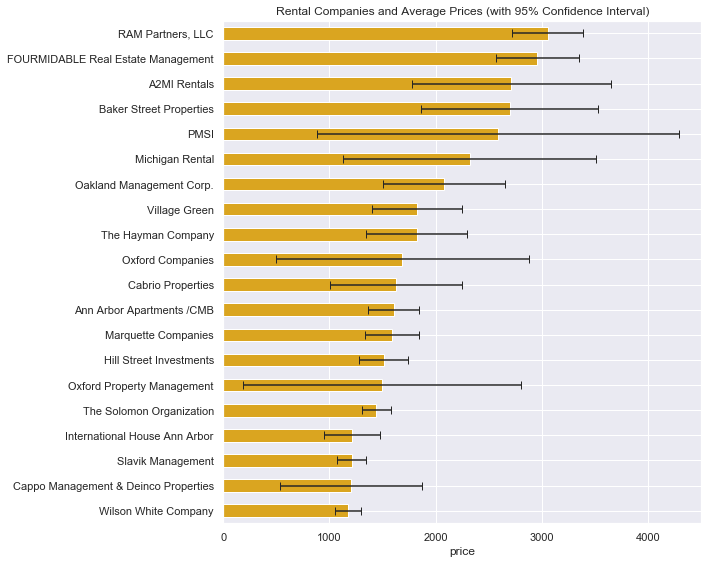

In [269]:
df_comp.price.plot(kind='barh', title='Rental Companies and Average Prices (with 95% Confidence Interval)', 
                  color='goldenrod', figsize=(10,8), xerr=error, capsize=4)
plt.xlabel('price')
plt.tight_layout()
plt.savefig('figures/Company vs Average Price', dpi=300)

### Distribution of Price by Number of Bathrooms

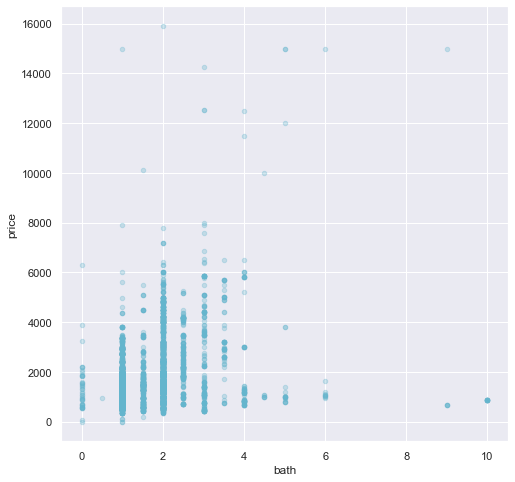

In [95]:
df.plot(kind='scatter', x='bath', y='price', color='c', figsize=(8,8), alpha=0.3) # add jitter?

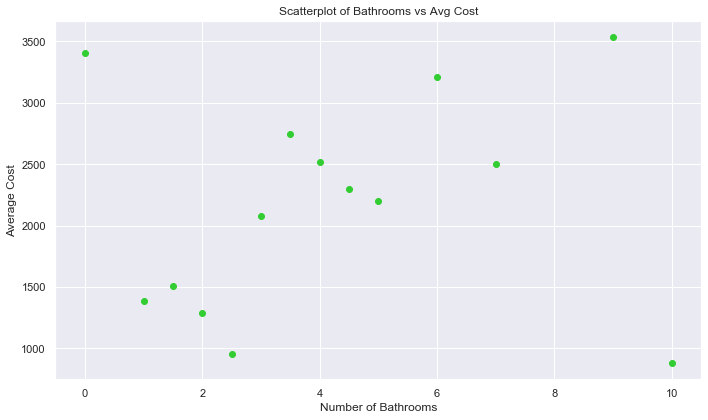

In [119]:
# Average cost
price_per_bath = df.groupby('bath')['price'].mean()
x1 = df['bath'].unique()
y1 = price_per_bath
x1 = x1[~np.isnan(x1)]

sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
plt.scatter(x=x1, y=y1, color='limegreen')
plt.title('Scatterplot of Bathrooms vs Avg Cost')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Average Cost')
plt.tight_layout()

### Distribution of Price by Pet Status

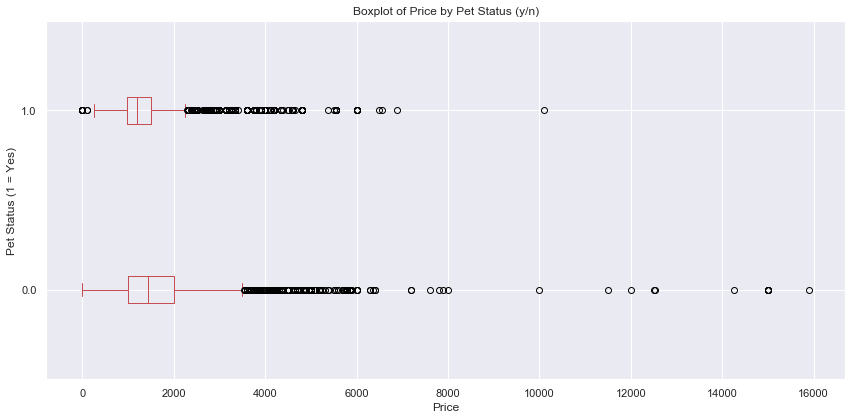

In [125]:
df.boxplot(column='price', by='pets', figsize=(12,6), vert=False, color='r')
plt.suptitle('') # removed default subtitle, it overlaps with title
plt.title('Boxplot of Price by Pet Status (y/n)')
plt.ylabel('Pet Status (1 = Yes)')
plt.xlabel('Price')
plt.tight_layout()

### Distribution of Price by Parking Status

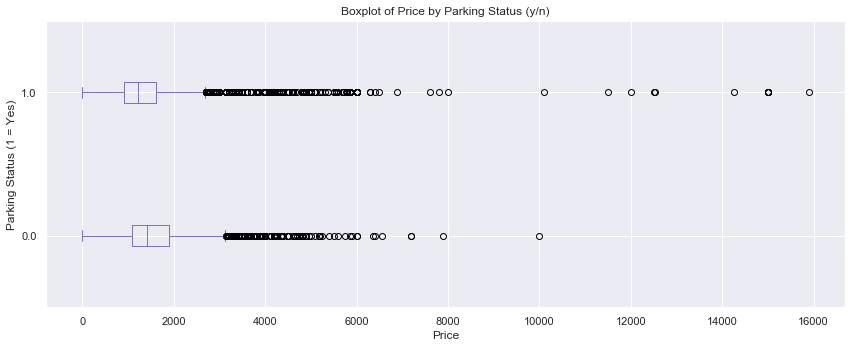

In [126]:
# PARKING STATUS
df.boxplot(column='price', by='parking', vert=False, figsize=(12,5), color='m')
plt.suptitle('') # removed default subtitle, it overlaps with title
plt.title('Boxplot of Price by Parking Status (y/n)')
plt.ylabel('Parking Status (1 = Yes)')
plt.xlabel('Price')
plt.tight_layout()

### Distribution of Price by Laundry Status

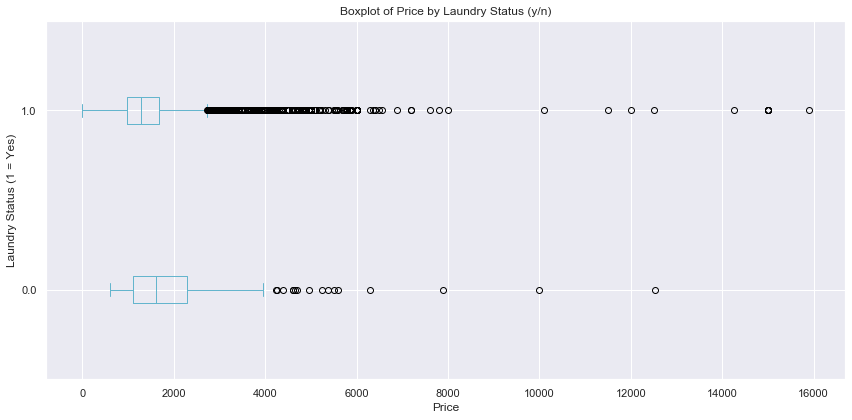

In [127]:
df.boxplot(column='price', by='laundry', vert=False, figsize=(12,6), color='c')
plt.suptitle('') # removed default subtitle, it overlaps with title
plt.title('Boxplot of Price by Laundry Status (y/n)')
plt.ylabel('Laundry Status (1 = Yes)')
plt.xlabel('Price')
plt.tight_layout()

### Marginal Distributions of Quantitative Variables 

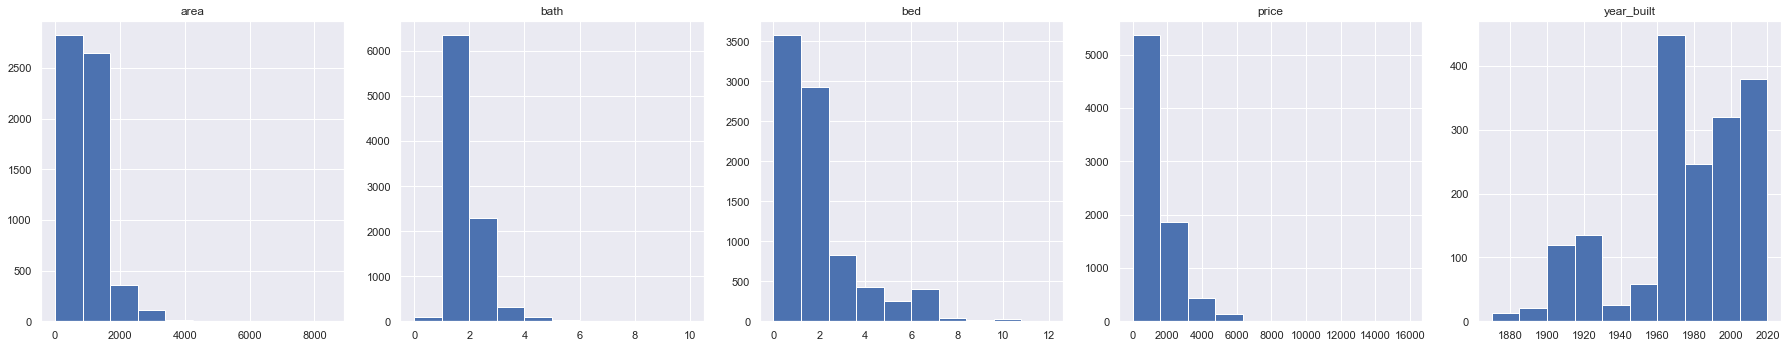

In [128]:
df_plot = df.drop(['laundry', 'parking', 'pets'], axis=1)
df_plot.hist(figsize=(25,5), layout=(1,5))
plt.tight_layout()

### Average Price by Binary Variables

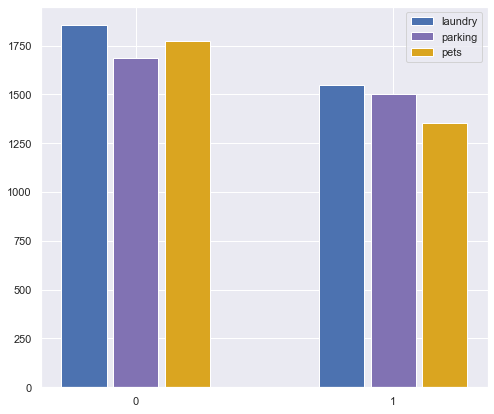

In [240]:
df_plot = df[['laundry', 'parking', 'pets']].dropna().astype(int)
laundry_price = df.groupby('laundry').mean()['price'].tolist()
parking_price = df.groupby('parking').mean()['price'].tolist()
pets_price = df.groupby('pets').mean()['price'].tolist()

r1 = [0, 2]
r2 = [0.4, 2.4]
r3 = [0.8, 2.8]

fig, ax = plt.subplots(figsize=(8,7))
plt.bar(x=r1, height=laundry_price, label='laundry', color='C0', width=0.35)
plt.bar(x=r2, height=parking_price, label='parking', color='C4', width=0.35)
plt.bar(x=r3, height=pets_price, label='pets', color='goldenrod', width=0.35)
ax.set_xticks([0.4, 2.4])
ax.set_xticklabels(('0', '1'))
ax.legend()

### Distribution of Price by Property Type

In [231]:
# Property Type and their price mean and standard deviation 
# if there is >1 instance of that property type
prop_group = df[~df['property_type'].isin(['cottage/cabin', 'garden style', 'triplex'])].groupby('property_type')

In [232]:
# compute 95% confidence intervals
means = prop_group.mean().price.to_numpy()

# sort in descending order by price
indices = np.argsort(means)
error = prop_group.price.std().to_numpy()[indices][::-1]
df_prop = prop_group.mean().sort_values(by='price', ascending=False)
col = {i: df_prop.index.to_list()[i] for i in np.arange(14)}
df_prop = pd.concat([df_prop.reset_index(), pd.DataFrame(error, columns=['error'])], axis=1)
df_prop = df_prop.rename(index=col).drop('property_type', axis=1)

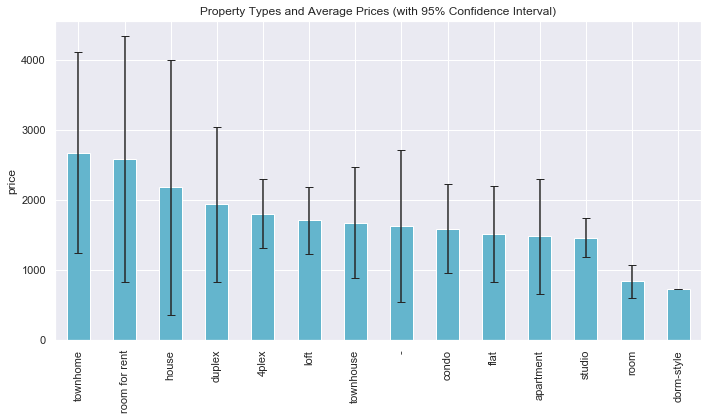

In [233]:
df_prop.price.plot(kind='bar', title='Property Types and Average Prices (with 95% Confidence Interval)', 
                  color='c', figsize=(10,6,), yerr=error, capsize=4)
plt.ylabel('price')
plt.tight_layout()
plt.savefig('figures/Property vs Average Price', dpi=300)